# Детекция дефектов сварки

## Detectron2 baseline

В данном ноутбуке представлен baseline модели детекции дефектов сварки с помощью фреймворка detectron2

# 0. Установка библиотек

Установка библиотек, под которым запускается данный бейзлайн.

In [ ]:
# %pip install torch torchvision -f https://download.pytorch.org/whl/torch_stable.html
# %pip install git+https://github.com/facebookresearch/detectron2.git
# %pip install tensorflow
# # -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
# %pip install opencv-python
# %pip install tensorrt

## 1. Загрузить необходимые библиотеки для создания и обучения модели

In [60]:
import json
import os
import random
import warnings

import cv2

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore")
import logging
import shutil

import detectron2
import ipywidgets as widgets
import numpy as np
import torch
import torchvision
from tqdm.notebook import tqdm
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
    build_detection_train_loader,
)
from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T
from detectron2.data.dataset_mapper import DatasetMapper
from detectron2.data.datasets import load_coco_json, register_coco_instances
from detectron2.engine import DefaultPredictor, DefaultTrainer, HookBase
from detectron2.evaluation import DatasetEvaluators
from detectron2.evaluation.coco_evaluation import COCOEvaluator
from detectron2.utils.visualizer import Visualizer
from ipywidgets import interact, interact_manual
from matplotlib import pyplot as plt

logger = logging.getLogger("detectron2")
logger.setLevel(logging.CRITICAL)

Прежде чем переходить к загрузке данных посмотрим, доступны ли нам GPU-мощности.

In [2]:
print("GPU: " + str(torch.cuda.is_available()))

GPU: True


# 2. Регистрация датасета

Зарегистрируем выборки в detectron2 для дальнейшей подачи на обучение модели.

In [4]:
for d in ["train", "val"]:
    DatasetCatalog.register(
        "my_dataset_" + d,
        lambda d=d: load_coco_json(
            "{}.json".format(d),
            image_root="datasets/dataset_very_very_new/images/{}".format(d),
            dataset_name="my_dataset_" + d,
            extra_annotation_keys=["bbox_mode"],
        ),
    )

После регистрации можно загружать выборки, чтобы иметь возможность посмотреть на них глазами. Первой загрузим обучающую выборку в **dataset_dicts_train**

In [5]:
dataset_dicts_train = DatasetCatalog.get("my_dataset_train")
train_metadata = MetadataCatalog.get("my_dataset_train")

И валидационную выборку в **dataset_dicts_val**

In [6]:
dataset_dicts_val = DatasetCatalog.get("my_dataset_val")
val_metadata = MetadataCatalog.get("my_dataset_val")

Посмотрим на размер получившихся выборок - эта операция в python осуществляется при помощи функции **len()**

In [7]:
print("Размер обучающей выборки (Картинки): {}".format(len(dataset_dicts_train)))
print("Размер валидационной выборки (Картинки): {}".format(len(dataset_dicts_val)))

Размер обучающей выборки (Картинки): 891
Размер валидационной выборки (Картинки): 271


Итак, у нас в распоряжении 891 изображения для тренировки, и 271 - для проверки качества.

**Посмотрим на размеченные фотографии из валидации**

In [8]:
import os

from IPython.display import Image


@interact
def show_images(file=range(len(dataset_dicts_val))):
    example = dataset_dicts_val[file]
    image = utils.read_image(example["file_name"], format="RGB")
    plt.figure(figsize=(3, 3), dpi=200)
    visualizer = Visualizer(image[:, :, ::-1], metadata=val_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(example)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

interactive(children=(Dropdown(description='file', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

##   4 Обучение модели

**4.1. Определяем конфигурацию**

Прежде чем начать работать с самой моделью, нам нужно определить ее параметры и спецификацию обучения

Создаем конфигурацию и загружаем архитектуру модели с предобученными весами (на COCO - датасете, содержащем $80$ популярных категорий объектов и более $300000$ изображений) для распознавания объектов.

In [10]:
cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"
)  # "drive/MyDrive/Сегментация рукописного текста/model_0000199.pth" #

Смотрел архитектуры в зоопарке [моделей](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md).

Теперь задаем параметры самой модели и обучения модели

In [11]:
# Загружаем названия обучающией и тестовой выборок в настройки
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

# Часто имеет смысл сделать изображения чуть меньшего размера, чтобы
# обучение происходило быстрее. Поэтому мы можем указать размер, до которого будем изменяться наименьшая
# и наибольшая из сторон исходного изображения.
cfg.INPUT.MIN_SIZE_TRAIN = 600
cfg.INPUT.MAX_SIZE_TRAIN = 800

# Также мы должны сказать модели ниже какой вероятности определения она игнорирует результат.
# То есть, если она найдет на картинке еду, но вероятность правильного определения ниже 0.5,
# то она не будет нам сообщать, что она что-то нашла.
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

cfg.TEST.EVAL_PERIOD = 500
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# Также мы должны указать порядок каналов во входном изображении. Обратите внимание, что это Blue Green Red (BGR),
# а не привычный RGB. Это особенности работы данной модели.
cfg.INPUT.FORMAT = "BGR"

# Для более быстрой загрузки данных в модель, мы делаем параллельную загрузку. Мы указываем параметр 4,
cfg.DATALOADER.NUM_WORKERS = 8

# Следующий параметр задает количество изображений в батче, на котором
# модель делает одну итерацию обучения (изменения весов).
cfg.SOLVER.IMS_PER_BATCH = 4

# Зададим также learning_rate
cfg.SOLVER.BASE_LR = 0.01

# Укажем модели, через сколько шагов обучения модели следует уменьшить learning rate
cfg.SOLVER.STEPS = (1000, 3000, 5000, 7000, 8000, 9000, 9500)

# Фактор, на который уменьшается learning rate задается следующим выражением
cfg.SOLVER.GAMMA = 0.1

# Зададим общее число итераций обучения.
cfg.SOLVER.MAX_ITER = 10000

# Укажем количество классов в нашей выборке
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5

# Задаем через сколько  шагов обучения сохранять веса модели в файл. Этот файл мы сможем загрузить потом
# для тестирования нашей обученной модели на новых данных.
cfg.SOLVER.CHECKPOINT_PERIOD = 1000

# И указываем название папки, куда сохранять чекпойнты модели и информацию о процессе обучения.
cfg.OUTPUT_DIR = "output/"

# Если вдруг такой папки нет, то создадим ее
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Если мы хотим удалить чекпойнты предыдущих моделей, то выполняем данную команду.
# %rm output/*

In [12]:
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder="output/"):
        coco_evaluator = COCOEvaluator(dataset_name, output_dir=output_folder)

        evaluator_list = [coco_evaluator]

        return DatasetEvaluators(evaluator_list)

    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(
            cfg,
            is_train=True,
            augmentations=[
                # T.Resize((800, 600)),
                T.RandomBrightness(0.8, 1.8),
                T.RandomContrast(0.6, 1.3),
                T.RandomSaturation(0.8, 1.4),
                # T.RandomRotation(angle=[90, 90]),
                T.RandomLighting(0.7),
                T.RandomFlip(prob=0.4, horizontal=True, vertical=False),
                T.RandomFlip(prob=0.4, horizontal=False, vertical=True),
            ],
        )

        return build_detection_train_loader(cfg, mapper=mapper)

**4.2. Обучаем модель**

Процесс обучения модели запускают следующие три строчки кода. Возможно будут предупреждения, на которые можно не обращать внимания, это информация об обучении.

In [13]:
# cfg.MODEL.WEIGHTS = "model_final.pth"

trainer = MyTrainer(cfg)
# Look at training curves in tensorboard:
# %load_ext tensorboard
# %tensorboard --logdir output
trainer.resume_or_load(resume=False)
trainer.train()

[06/15 20:42:41 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[06/15 20:42:41 d2.engine.train_loop]: Starting training from iteration 0
[06/15 20:42:54 d2.utils.events]:  eta: 0:56:49  iter: 19  total_loss: 2.364  loss_cls: 1.592  loss_box_reg: 0.03656  loss_rpn_cls: 0.7578  loss_rpn_loc: 0.062    time: 0.4137  last_time: 0.2778  data_time: 0.1621  last_data_time: 0.0014   lr: 2.881e-05  max_mem: 2741M


2024-06-15 20:42:54.807682: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 20:42:56.188401: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[06/15 20:43:05 d2.utils.events]:  eta: 0:57:26  iter: 39  total_loss: 1.388  loss_cls: 0.7783  loss_box_reg: 0.0591  loss_rpn_cls: 0.3571  loss_rpn_loc: 0.06101    time: 0.4063  last_time: 0.2934  data_time: 0.0930  last_data_time: 0.0103   lr: 4.861e-05  max_mem: 2741M
[06/15 20:43:14 d2.utils.events]:  eta: 0:57:05  iter: 59  total_loss: 0.674  loss_cls: 0.2976  loss_box_reg: 0.0662  loss_rpn_cls: 0.2098  loss_rpn_loc: 0.07339    time: 0.4093  last_time: 0.3089  data_time: 0.1165  last_data_time: 0.0187   lr: 6.841e-05  max_mem: 2741M
[06/15 20:43:22 d2.utils.events]:  eta: 0:58:42  iter: 79  total_loss: 0.4339  loss_cls: 0.1665  loss_box_reg: 0.0798  loss_rpn_cls: 0.1142  loss_rpn_loc: 0.04999    time: 0.4076  last_time: 0.5566  data_time: 0.1090  last_data_time: 0.2460   lr: 8.821e-05  max_mem: 2741M
[06/15 20:43:30 d2.utils.events]:  eta: 0:59:23  iter: 99  total_loss: 0.4911  loss_cls: 0.1919  loss_box_reg: 0.1137  loss_rpn_cls: 0.1226  loss_rpn_loc: 0.05726    time: 0.4086  las

Используем обученную модель для проверки качества на валидации.

In [21]:
cfg.MODEL.WEIGHTS = (
    "output/model_final.pth"  # drive/MyDrive/Сегментация рукописного текста/
)

cfg.DATASETS.TEST = ("my_dataset_val",)

# ВАЖНО увеличить это значение (стандартное равно 100). Так как на листе тетради может быть довольно много слов
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1

predictor = DefaultPredictor(cfg)

trainer.test(cfg, trainer.model)

[06/15 22:12:17 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/model_final.pth ...
WARNING [06/15 22:12:17 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/15 22:12:17 d2.data.datasets.coco]: Loaded 271 images in COCO format from val.json
[06/15 22:12:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/15 22:12:17 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/15 22:12:17 d2.data.common]: Serializing 271 elements to byte tensors and concatenating them all ...
[06/15 22:12:17 d2.data.common]: Serialized dataset takes 0.10 MiB
[06/15 22:12:17 d2.evaluation.evaluator]: Start inference on 271 batches
[06/15 22:12:20 d2.evaluation.evaluator]: Inference done 11/271. Dataloading: 0.0765 s/iter. Inference: 0.0767 s/ite

OrderedDict([('bbox',
              {'AP': 2.661911779273,
               'AP50': 10.411555445855878,
               'AP75': 0.3788228683193983,
               'APs': nan,
               'APm': 2.415949159958713,
               'APl': 3.4651332848063063,
               'AP-adj': 9.59955028596138,
               'AP-int': 0.2695269526952695,
               'AP-geo': 0.5356661761601926,
               'AP-pro': 1.1622412241224123,
               'AP-non': 1.7425742574257423})])

Сделаем предсказания для тестового датасета и сразу же нарисуем его.

Вы можете выбрать из выпадающего списка номер изображения, и посмотреть разметку на всем валидационном датасете.

In [22]:
dataset_dicts_val[131]

{'file_name': 'datasets/dataset_very_very_new/images/val/4 (80).jpg',
 'height': 2160,
 'width': 3840,
 'image_id': 132,
 'annotations': [{'iscrowd': 0,
   'bbox': [1440.29376, 1299.5532, 567.67104, 205.59312],
   'category_id': 2,
   'bbox_mode': <BoxMode.XYWH_ABS: 1>},
  {'iscrowd': 0,
   'bbox': [2362.1740800000002, 2.536919999999989, 302.60352, 304.58376],
   'category_id': 0,
   'bbox_mode': <BoxMode.XYWH_ABS: 1>},
  {'iscrowd': 0,
   'bbox': [2509.9584, 390.88007999999996, 150.12864, 167.52096],
   'category_id': 0,
   'bbox_mode': <BoxMode.XYWH_ABS: 1>},
  {'iscrowd': 0,
   'bbox': [2097.10272, 1022.89068, 131.36256, 241.12727999999998],
   'category_id': 0,
   'bbox_mode': <BoxMode.XYWH_ABS: 1>},
  {'iscrowd': 0,
   'bbox': [1989.1987199999999, 1350.31644, 121.97760000000001, 187.82712],
   'category_id': 0,
   'bbox_mode': <BoxMode.XYWH_ABS: 1>},
  {'iscrowd': 0,
   'bbox': [961.7606399999999,
    408.64932000000005,
    68.02560000000001,
    357.88392],
   'category_id': 0,


In [23]:
@interact
def show_images(file=range(len(dataset_dicts_val))):

    example = dataset_dicts_val[file]
    im = cv2.imread(example["file_name"])
    outputs = predictor(im)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10), dpi=400)
    v = Visualizer(im[:, :], metadata=val_metadata, scale=0.4)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    image = utils.read_image(example["file_name"], format="RGB")
    visualizer = Visualizer(image[:, :, ::-1], metadata=val_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(example)

    axs[0].imshow(vis.get_image()[:, :, ::-1])
    axs[1].imshow(v.get_image()[:, :, ::-1])
    axs[0].axis("off")
    axs[1].axis("off")
    axs[0].set_title("Original")
    axs[1].set_title("Predict")
    plt.show()

interactive(children=(Dropdown(description='file', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

Можно непосредственно в коде изменить номер изображения, которое Вы хотите обработать.

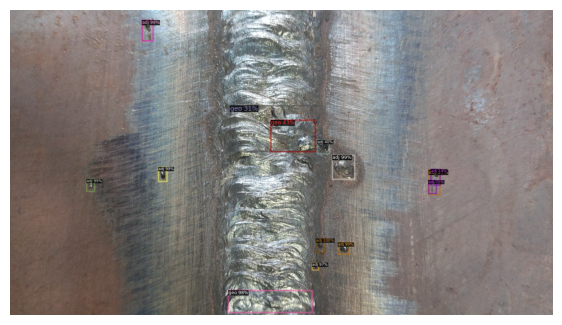

In [24]:
id_image_selected = 3
example = dataset_dicts_val[id_image_selected]
im = cv2.imread(example["file_name"])
outputs = predictor(im)
plt.figure(figsize=(7, 7))
v = Visualizer(im[:, :], metadata=val_metadata, scale=0.4)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()

# Запись submission

Возьмем нашу обученную модель и запишем предсказания в файл `submission_detr.csv`

In [66]:
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.structures import Boxes, BoxMode

import csv

In [71]:
def run(test_images_path, predictions_output_path):
    threshold = 0.1
    model_path = ("model_final.pth")

    cfg = get_cfg()
    cfg.merge_from_file(
        model_zoo.get_config_file(
            "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"
        )
    )
    cfg.MODEL.WEIGHTS = model_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = (
        threshold  # set the testing threshold for this model
    )
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5
    cfg.INPUT.MIN_SIZE_TEST = 600
    cfg.INPUT.MAX_SIZE_TEST = 800
    cfg.INPUT.FORMAT = "BGR"
    cfg.TEST.DETECTIONS_PER_IMAGE = 1000

    predictor = DefaultPredictor(cfg)
    results = []

    for img in tqdm(os.listdir(test_images_path)):
        if img == '.ipynb_checkpoints':
            continue
        
        img_path = os.path.join(test_images_path, img)
        im = cv2.imread(img_path)
        outputs = predictor(im)
        prediction = outputs["instances"].pred_boxes.tensor.cpu().numpy()
        img_height, img_width, _ = im.shape

        prediction[:, 0], prediction[:, 2] = (prediction[:, 2] + prediction[:, 0]) // 2, (prediction[:, 2] - prediction[:, 0]) // 2
        prediction[:, 1], prediction[:, 3] = (prediction[:, 1] + prediction[:, 3]) // 2, (prediction[:, 3] - prediction[:, 1]) // 2

        prediction[:, [0, 2]] /= img_width
        prediction[:, [1, 3]] /= img_height

        labels = outputs["instances"].pred_classes.cpu().numpy()

        for label, bbox in zip(labels, prediction):
            results.append([img, label, *bbox])
    
    with open(predictions_output_path, mode="w") as f:
        csv_writer = csv.writer(f, delimiter=";", lineterminator="\n")
        csv_writer.writerow("filename;class_id;rel_x;rel_y;width;height".split(";"))
        csv_writer.writerows(results)

In [72]:
run("datasets/dataset_very_very_new/images/val", 'submission_detr.csv')

  0%|          | 0/272 [00:00<?, ?it/s]